In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import seaborn as sn
import pandas as pd

from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

sn.set_style('whitegrid')

In [2]:
data_train = np.loadtxt('data/mnist_train.csv', skiprows=1, delimiter=',')
data_test = np.loadtxt('data/mnist_test.csv', skiprows=1, delimiter=',')

X_train, y_train = torch.tensor(data_train[:, 1:] / 255).float().cuda(), torch.tensor(data_train[:, 0]).long().cuda()
X_test, y_test = data_test[:, 1:] / 255, data_test[:, 0]

In [3]:
def generate_batches(X, y, batch_size=512):
    for i in range(0, X.shape[0], batch_size):
        batch = slice(i, i + batch_size)
        X_batch, y_batch = X[batch], y[batch]
        
        yield X_batch, y_batch

In [4]:
class FNN(nn.Module):
    def __init__(self, input_size, hidden_size=256):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)
        
        self.cuda()


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return self.fc3(x)

    
    def predict(self, x):
        x = torch.tensor(x).float().cuda()
        with torch.no_grad():
            
            return self.forward(x).argmax(-1).detach().cpu().numpy()

In [5]:
model = FNN(X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model, optimizer

(FNN(
   (fc1): Linear(in_features=784, out_features=256, bias=True)
   (fc2): Linear(in_features=256, out_features=256, bias=True)
   (fc3): Linear(in_features=256, out_features=10, bias=True)
 ),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.0001
     weight_decay: 0
 ))

Epoch: 49, loss: 0.09410730461968342: 100%|██████████| 50/50 [00:30<00:00,  1.62it/s]

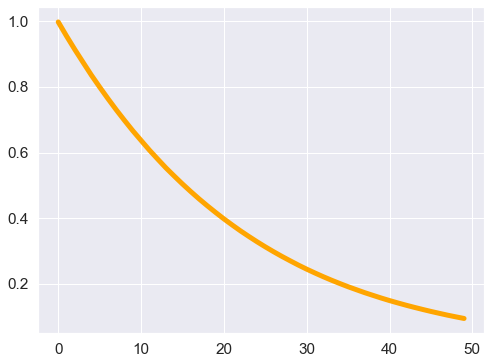

In [13]:
losses = [0]
n_epochs = 50
pbar = tqdm(range(n_epochs), total=n_epochs, leave=False, position=0)
for epoch in pbar:
    for X_batch, y_batch in generate_batches(X_train, y_train):
        y_hat = model(X_batch)
        loss = F.cross_entropy(y_hat, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses[-1] += loss.item()
    pbar.set_description(f'Epoch: {epoch}, loss: {losses[-1]}')
    losses.append(0)

plt.figure(figsize=(8, 6))
plt.plot(list(range(n_epochs)), losses[:-1], 'orange', lw=5)
plt.grid(True)
plt.show()

In [7]:
print(f'Accuracy on test data: {np.mean(y_test == model.predict(X_test))}')

Accuracy on test data: 0.9753


In [8]:
def fast_adversarial_example(dig, n=784, eta=0.01, iters=10):
    y = torch.tensor([dig]).long().cuda()
    x = torch.tensor(np.random.normal(loc=0, scale=0.01, size=n)).float().cuda()
    for _ in range(iters):    
        x = torch.tensor(x, requires_grad=True).cuda()
        y_hat = model(x).unsqueeze(0)
        loss = F.cross_entropy(y_hat, y)
        model.zero_grad()
        loss.backward()
        x = torch.clamp(x - eta * torch.sign(x.grad.data), 0.0, 1.0)
        
    return x

In [9]:
example = fast_adversarial_example(7, eta=0.1, iters=10)

alpha = 0.5
X_spoiled = np.maximum(X_test * (1-alpha), alpha * example.detach().cpu().numpy())
y_pred = model.predict(X_spoiled)

In [10]:
print(f'Accuracy on spoiled data: {np.mean(y_test == y_pred)}')

Accuracy on spoiled data: 0.1053


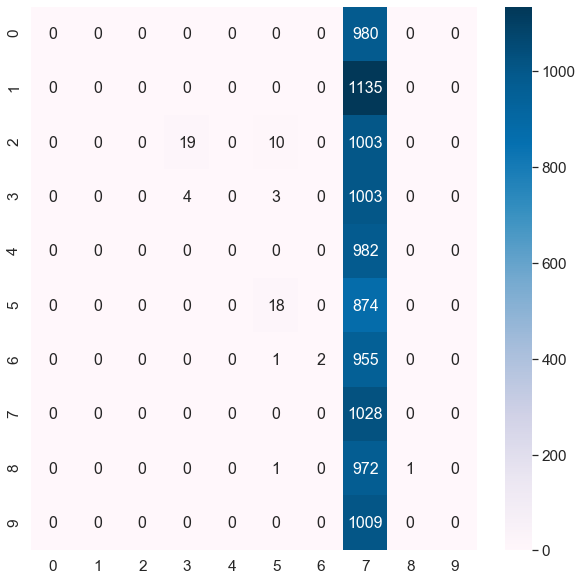

In [11]:
conf_mat = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(conf_mat, range(10), range(10))

plt.figure(figsize=(10, 10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap='PuBu', annot=True, fmt='d', annot_kws={"size": 16})
plt.show()